In [1]:
import numpy as np
import torch
from torch import nn
import LightPipes as lp
import matplotlib.pyplot as plt
import os, sys, h5py
main_dir = os.path.abspath('../')
sys.path.append(main_dir)

from utils.functions import *
from utils.models.modalevaluator import ModalEvaluator
from utils.modes.vortex import Vortex


device = 'cuda:2'

from matplotlib import rc
rc('font',**{'family':'sans-serif','sans-serif':['Helvetica']})
rc('text', usetex=True)


truncate_circle = True

In [23]:
size = 20
xx, yy = torch.meshgrid(torch.linspace(-1,1,size), torch.linspace(-1,1,size))

wavefront, dx, dy = Vortex(xx,yy)
microlens_pitch = 150e-6

dx /= microlens_pitch 
dy /= microlens_pitch

dx *=2
dy*=2 #m=2 vortex plate

sampled_gradient = torch.concatenate([dx, dy], dim=0)

## From here I show once we have gradients


In [26]:
wl = 800e-9
pixelsize = 3.45e-6
microlens_pitch = 150e-6


size = sampled_gradient.shape[2]
n_zernike_rows = 5
n_zernike = n_zernike_rows*(n_zernike_rows+1)//2


num_inits = 25

evaller = ModalEvaluator(size=(size,size), initializations=num_inits, n_zernike_rows=n_zernike_rows, zern_transform=True, pixel_basis=True, special_mode=Vortex,
                            microlens_pitch=microlens_pitch, device=device)

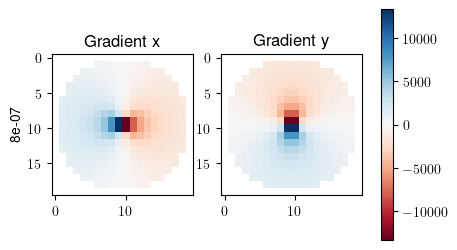

In [27]:

fig,ax = plt.subplots(1,2,figsize=(5,5))
ax[0].imshow(sampled_gradient[0], cmap='RdBu');ax[0].set_title('Gradient x')
im = ax[1].imshow(sampled_gradient[1], cmap='RdBu');ax[1].set_title('Gradient y')
ax[0].set_ylabel(wl)

fig.colorbar(im, ax=ax.ravel().tolist(), shrink=0.6)

In [28]:
init_transX, init_transY = np.meshgrid(np.linspace(-.02, .02, 5), np.linspace(-.02, .02, 5))
init_rot = np.array([0]*num_inits) #np.repeat(np.linspace(0, 2*np.pi, 5), 5)

init_rot, init_transX, init_transY = init_rot, init_transX.flatten(), init_transY.flatten()

coeffs, history = evaller.fit(sampled_gradient, affine_initialization=[init_rot, init_transX, init_transY], epochs=8000, lr=2e-3, l1_reg=1e-3)

/home/s/Sunny.Howard/overdictionary/utils/models/modalevaluator.py:78: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  wavefront_derivs = torch.tensor(wavefront_derivs).permute(1,0).tile(self.initializations,1).float().to(self.device)


tensor(1.9986)


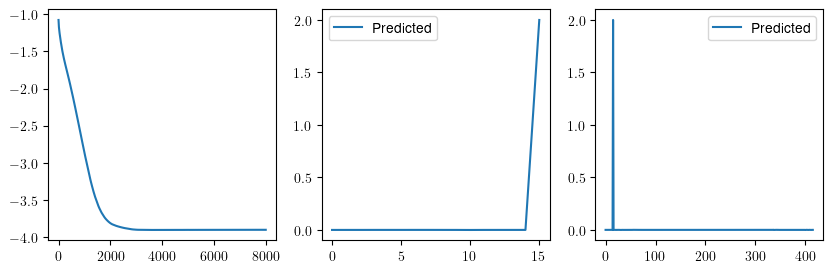

In [29]:
fig,ax = plt.subplots(1,3, figsize = (10,3))
ax[0].plot(np.log10(history['loss']))
ax[1].plot(coeffs['coefficients'][evaller.best_init,:n_zernike+1].detach().cpu())
ax[1].legend(['Predicted'])
ax[2].plot(coeffs['coefficients'][evaller.best_init,:].detach().cpu())
ax[2].legend(['Predicted'])

print(coeffs['coefficients'][evaller.best_init,n_zernike].detach().cpu())